# Лаборатораня работа №3: Обработка признаков (часть 2).

In [3]:
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru.
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from matplotlib import pyplot as plt
import seaborn as sns
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from warnings import simplefilter

simplefilter('ignore')

In [4]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';')

In [5]:
# смотрим на первые пять строк
data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0.0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0.0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0.0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0.0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0.0


## 1) Обработка пропусков в данных

In [6]:
#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82356 entries, 0 to 82355
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             82356 non-null  int64  
 1   gender                82356 non-null  object 
 2   age                   82353 non-null  float64
 3   marital_status        82353 non-null  object 
 4   job_position          82356 non-null  object 
 5   credit_sum            82354 non-null  object 
 6   credit_month          82356 non-null  int64  
 7   tariff_id             82356 non-null  float64
 8   score_shk             82349 non-null  object 
 9   education             82350 non-null  object 
 10  living_region         82261 non-null  object 
 11  monthly_income        82350 non-null  float64
 12  credit_count          77921 non-null  float64
 13  overdue_credit_count  77921 non-null  float64
 14  open_account_flg      82355 non-null  float64
dtypes: float64(6), int6

In [7]:
#удаляем столбец с номером клиента (так как он незначимый)
# и с регионом проживания (так как он нуждается в серьезной предобработке)
data.drop(['client_id', 'living_region'], axis=1, inplace=True)

In [8]:
# анализируем столбец marital_status, смотрим, какое значение в нем является самым частым
data['marital_status'].describe()

count     82353
unique        5
top         MAR
freq      45350
Name: marital_status, dtype: object

In [9]:
# анализируем столбец education, смотрим, какое в нем самое частое значение
data['education'].describe()

count     82350
unique        5
top         SCH
freq      42228
Name: education, dtype: object

In [10]:
# дозаполняем нечисловые столбцы с пропусками самыми часто встречающимися значениями
data['marital_status'].fillna('MAR', inplace=True)
data['education'].fillna('SCH', inplace=True)

In [11]:
# дозаполняем числовые столбцы с пропусками медианными значениями
data['age'].fillna(data['age'].median(), inplace=True)
data['credit_count'].fillna(data['credit_count'].median(), inplace=True)
data['overdue_credit_count'].fillna(data['overdue_credit_count'].median(), inplace=True)

In [12]:
#меняем в столбцах 'credit_sum', 'score_shk'  запятые на точки  и преобразуем их в числовой  формат
for i in ['credit_sum', 'score_shk']:
    data[i] = data[i].str.replace(',', '.').astype('float')

In [13]:
# дозаполняем ставшие теперь числовыми столбцы 'credit_sum', 'score_shk'   медианными значениями
data['score_shk'].fillna(data['score_shk'].median(), inplace=True)
data['monthly_income'].fillna(data['monthly_income'].median(), inplace=True)
data['credit_sum'].fillna(data['credit_sum'].median(), inplace=True)

In [14]:
# смотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82356 entries, 0 to 82355
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                82356 non-null  object 
 1   age                   82356 non-null  float64
 2   marital_status        82356 non-null  object 
 3   job_position          82356 non-null  object 
 4   credit_sum            82356 non-null  float64
 5   credit_month          82356 non-null  int64  
 6   tariff_id             82356 non-null  float64
 7   score_shk             82356 non-null  float64
 8   education             82356 non-null  object 
 9   monthly_income        82356 non-null  float64
 10  credit_count          82356 non-null  float64
 11  overdue_credit_count  82356 non-null  float64
 12  open_account_flg      82355 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.2+ MB


## 2) Кодирование категориальных признаков

In [15]:
category_cols = ['gender', 'job_position', 'education', 'marital_status']

In [16]:
print("Количество уникальных значений\n")
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

gender: 2
job_position: 17
education: 5
marital_status: 5


In [17]:
# кодируем нечисловые столбцы методом дамми-кодирования
data = pd.concat([data,
                      pd.get_dummies(data['gender'], prefix="gender"),
                      pd.get_dummies(data['job_position'], prefix="job_position"),
                      pd.get_dummies(data['education'], prefix="education"),
                      pd.get_dummies(data['marital_status'], prefix="marital_status")],
                     axis=1)

In [18]:
#удаляем старые нечисловые столбцы, вместо них уже появились новые числовые
data.drop(['gender','job_position','education','marital_status'], axis=1, inplace=True)

In [19]:
data.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,34.0,59998.00,10,1.6,0.461639,30000.0,1.0,1.0,0.0,0,...,0,1,0,0,0,0,0,1,0,0
1,34.0,10889.00,6,1.1,0.461639,35000.0,2.0,0.0,0.0,1,...,0,0,0,1,0,0,0,1,0,0
2,32.0,10728.00,12,1.1,0.461639,35000.0,5.0,0.0,0.0,0,...,0,0,0,1,0,0,0,1,0,0
3,27.0,12009.09,12,1.1,0.461639,35000.0,2.0,0.0,0.0,1,...,0,0,0,1,0,0,0,1,0,0
4,45.0,21197.50,10,1.1,0.421385,35000.0,1.0,0.0,0.0,0,...,0,0,0,1,0,0,0,1,0,0


## 3) Обработка выбросов для числовых признаков

Замена выбросов

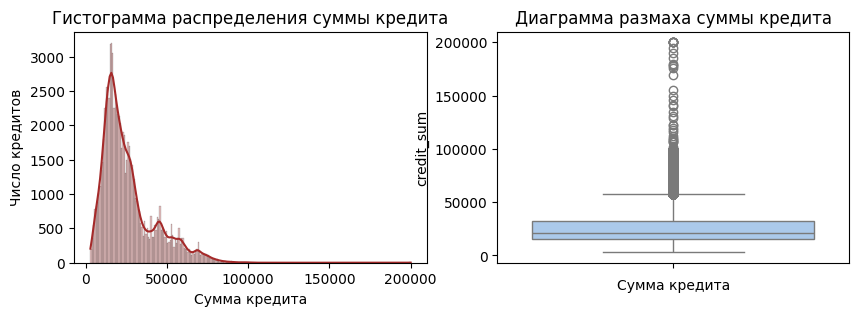

In [20]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 2)
sns.histplot(data['credit_sum'], kde=True, color='brown', alpha=0.3, ax=axes[0])
axes[0].title.set_text(f"Гистограмма распределения суммы кредита")
axes[0].set_xlabel('Сумма кредита')
axes[0].set_ylabel('Число кредитов')
sns.boxplot(data['credit_sum'], palette='pastel', ax=axes[1])
axes[1].title.set_text(f"Диаграмма размаха суммы кредита")
axes[1].set_xlabel('Сумма кредита')
plt.show();

In [21]:
K = 1.5
col = 'credit_sum'
IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
lower_boundary = data[col].quantile(0.25) - (K * IQR)
upper_boundary = data[col].quantile(0.75) + (K * IQR)
round(lower_boundary, 2), round(upper_boundary, 2)

(-10718.88, 57758.12)

In [22]:
data[col] = np.where(data[col] > upper_boundary, upper_boundary, np.where(data[col] < lower_boundary, lower_boundary, data[col]))

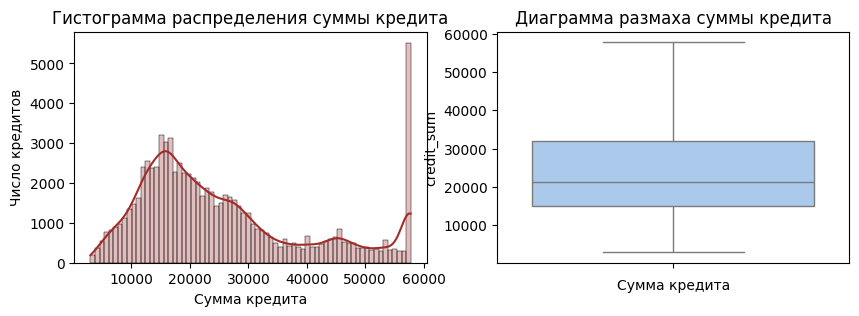

In [23]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 2)
sns.histplot(data['credit_sum'], kde=True, color='brown', alpha=0.3, ax=axes[0])
axes[0].title.set_text(f"Гистограмма распределения суммы кредита")
axes[0].set_xlabel('Сумма кредита')
axes[0].set_ylabel('Число кредитов')
sns.boxplot(data['credit_sum'], palette='pastel', ax=axes[1])
axes[1].title.set_text(f"Диаграмма размаха суммы кредита")
axes[1].set_xlabel('Сумма кредита')
plt.show();

Удаление выбросов

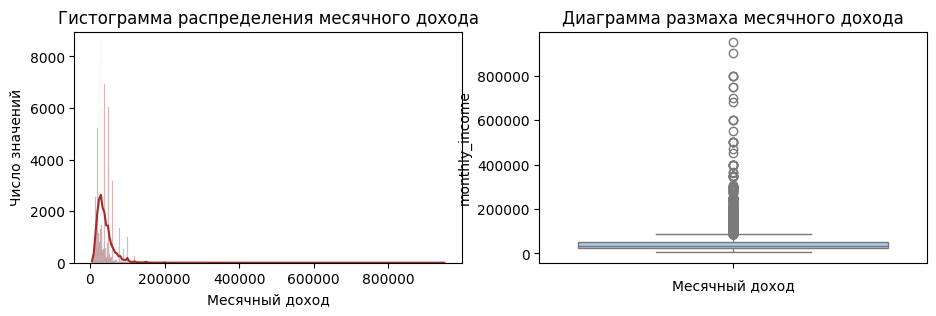

In [24]:
fig = plt.figure(figsize=(11, 3))
axes = fig.subplots(1, 2)
sns.histplot(data['monthly_income'], kde=True, color='brown', alpha=0.3, ax=axes[0])
axes[0].title.set_text(f"Гистограмма распределения месячного дохода")
axes[0].set_xlabel('Месячный доход')
axes[0].set_ylabel('Число значений')
sns.boxplot(data['monthly_income'], palette='pastel', ax=axes[1])
axes[1].title.set_text(f"Диаграмма размаха месячного дохода")
axes[1].set_xlabel('Месячный доход')
plt.show();

In [25]:
K = 1.5
col = 'monthly_income'
IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
lower_boundary = data[col].quantile(0.25) - (K * IQR)
upper_boundary = data[col].quantile(0.75) + (K * IQR)
round(lower_boundary, 2), round(upper_boundary, 2)

(-12500.0, 87500.0)

In [26]:
data = data[data['monthly_income'] < 87500.0]

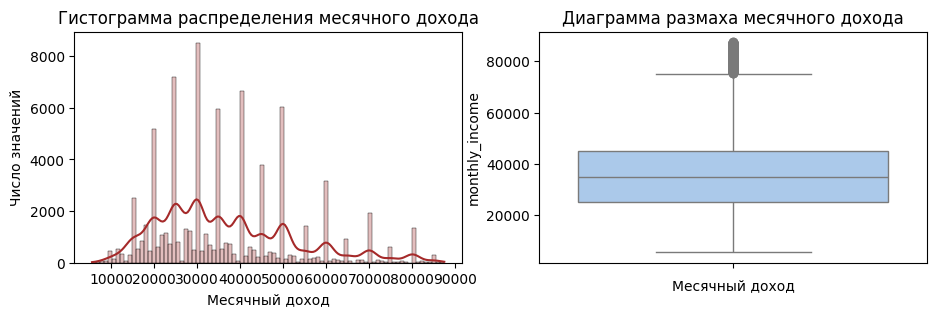

In [27]:
fig = plt.figure(figsize=(11, 3))
axes = fig.subplots(1, 2)
sns.histplot(data['monthly_income'], kde=True, color='brown', alpha=0.3, ax=axes[0])
axes[0].title.set_text(f"Гистограмма распределения месячного дохода")
axes[0].set_xlabel('Месячный доход')
axes[0].set_ylabel('Число значений')
sns.boxplot(data['monthly_income'], palette='pastel', ax=axes[1])
axes[1].title.set_text(f"Диаграмма размаха месячного дохода")
axes[1].set_xlabel('Месячный доход')
plt.show();

## 4) Масштабирование данных

In [28]:
numeric_columns = [column for column in data.columns if data.dtypes[column] != object]

In [29]:
numeric_columns

['age',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'monthly_income',
 'credit_count',
 'overdue_credit_count',
 'open_account_flg',
 'gender_F',
 'gender_M',
 'job_position_ATP',
 'job_position_BIS',
 'job_position_BIU',
 'job_position_DIR',
 'job_position_HSK',
 'job_position_INP',
 'job_position_INV',
 'job_position_NOR',
 'job_position_PNA',
 'job_position_PNI',
 'job_position_PNS',
 'job_position_PNV',
 'job_position_SPC',
 'job_position_UMN',
 'job_position_WOI',
 'job_position_WRK',
 'job_position_WRP',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'marital_status_CIV',
 'marital_status_DIV',
 'marital_status_MAR',
 'marital_status_UNM',
 'marital_status_WID']

In [30]:
data1 = pd.DataFrame(StandardScaler().fit_transform(data[numeric_columns]), columns=numeric_columns);
data1.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,-0.231430,2.318766,-0.278885,1.167152,-0.079149,-0.423702,-0.627306,4.651151,-0.463232,-1.056346,...,-0.023868,1.193900,-0.054377,-1.054043,-0.247877,-0.159677,-0.33398,0.913604,-0.667951,-0.147237
1,-0.231430,-0.992644,-1.413550,-0.950709,-0.079149,-0.113102,-0.041424,-0.211013,-0.463232,0.946659,...,-0.023868,-0.837591,-0.054377,0.948728,-0.247877,-0.159677,-0.33398,0.913604,-0.667951,-0.147237
2,-0.419776,-1.004019,0.288447,-0.950709,-0.079149,-0.113102,1.716222,-0.211013,-0.463232,-1.056346,...,-0.023868,-0.837591,-0.054377,0.948728,-0.247877,-0.159677,-0.33398,0.913604,-0.667951,-0.147237
3,-0.890641,-0.913507,0.288447,-0.950709,-0.079149,-0.113102,-0.041424,-0.211013,-0.463232,0.946659,...,-0.023868,-0.837591,-0.054377,0.948728,-0.247877,-0.159677,-0.33398,0.913604,-0.667951,-0.147237
4,0.804473,-0.264325,-0.278885,-0.950709,-0.403861,-0.113102,-0.627306,-0.211013,-0.463232,-1.056346,...,-0.023868,-0.837591,-0.054377,0.948728,-0.247877,-0.159677,-0.33398,0.913604,-0.667951,-0.147237


In [31]:
data1.describe()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
count,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903300e+04,7.903400e+04,...,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04,7.903400e+04
mean,8.055347e-17,-6.715786e-16,3.955751e-18,-6.535080e-16,2.672829e-16,8.468903e-17,7.066409e-17,-5.502090e-17,-2.355500e-17,7.138332e-17,...,1.798069e-18,2.625180e-17,-4.656997e-17,7.336120e-17,-3.074697e-17,1.474416e-17,-5.942616e-17,-3.182581e-17,-7.228235e-17,-4.315364e-18
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.738198e+00,-1.550020e+00,-2.264549e+00,-1.374281e+00,-3.802993e+00,-1.939428e+00,-1.213188e+00,-2.110133e-01,-4.632324e-01,-1.056346e+00,...,-2.386838e-02,-8.375910e-01,-5.437661e-02,-1.054043e+00,-2.478774e-01,-1.596767e-01,-3.339797e-01,-1.094566e+00,-6.679509e-01,-1.472369e-01
25%,-7.964679e-01,-7.178068e-01,-2.788854e-01,-9.507088e-01,-7.262172e-01,-7.343014e-01,-6.273059e-01,-2.110133e-01,-4.632324e-01,-1.056346e+00,...,-2.386838e-02,-8.375910e-01,-5.437661e-02,-1.054043e+00,-2.478774e-01,-1.596767e-01,-3.339797e-01,-1.094566e+00,-6.679509e-01,-1.472369e-01
50%,-2.314300e-01,-2.885943e-01,-2.788854e-01,-1.884996e-02,-6.432267e-02,-1.131020e-01,-4.142405e-02,-2.110133e-01,-4.632324e-01,9.466592e-01,...,-2.386838e-02,-8.375910e-01,-5.437661e-02,9.487276e-01,-2.478774e-01,-1.596767e-01,-3.339797e-01,9.136038e-01,-6.679509e-01,-1.472369e-01
75%,6.161268e-01,4.294978e-01,2.884469e-01,1.167152e+00,6.655166e-01,5.080973e-01,5.444579e-01,-2.110133e-01,-4.632324e-01,9.466592e-01,...,-2.386838e-02,1.193900e+00,-5.437661e-02,9.487276e-01,-2.478774e-01,-1.596767e-01,-3.339797e-01,9.136038e-01,1.497116e+00,-1.472369e-01
max,3.252970e+00,2.318766e+00,7.096435e+00,2.692012e+00,5.298447e+00,3.141983e+00,9.918568e+00,1.437548e+01,2.158743e+00,9.466592e-01,...,4.189643e+01,1.193900e+00,1.839026e+01,9.487276e-01,4.034252e+00,6.262656e+00,2.994194e+00,9.136038e-01,1.497116e+00,6.791775e+00


In [32]:
data2 = pd.DataFrame(MinMaxScaler().fit_transform(data[numeric_columns]), columns=numeric_columns);
data2.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,0.301887,1.000000,0.212121,0.625000,0.409149,0.298289,0.052632,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.301887,0.144070,0.090909,0.104167,0.409149,0.359413,0.105263,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.264151,0.141130,0.272727,0.104167,0.409149,0.359413,0.263158,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.169811,0.164525,0.272727,0.104167,0.409149,0.359413,0.105263,0.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.509434,0.332325,0.212121,0.104167,0.373472,0.359413,0.052632,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
data2.describe()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
count,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79033.000000,79034.000000,...,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000
mean,0.348255,0.400648,0.241914,0.337969,0.417845,0.381671,0.108984,0.014466,0.176673,0.527381,...,0.000569,0.412304,0.002948,0.526292,0.057886,0.024863,0.100349,0.545057,0.308513,0.021219
std,0.200355,0.258481,0.106827,0.245926,0.109873,0.196797,0.089834,0.068557,0.381394,0.499253,...,0.023855,0.492252,0.054217,0.499311,0.233530,0.155708,0.300467,0.497969,0.461882,0.144114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188679,0.215110,0.212121,0.104167,0.338054,0.237164,0.052632,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.301887,0.326052,0.212121,0.333333,0.410778,0.359413,0.105263,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.471698,0.511664,0.272727,0.625000,0.490967,0.481663,0.157895,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
data3 = pd.DataFrame(RobustScaler().fit_transform(data[numeric_columns]), columns=numeric_columns);
data3.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,0.000000,2.272596,0.0,0.56,-0.010653,-0.25,-0.5,1.0,0.0,-1.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,-0.613656,-2.0,-0.44,-0.010653,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.133333,-0.623570,1.0,-0.44,-0.010653,0.00,1.5,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.466667,-0.544679,1.0,-0.44,-0.010653,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.733333,0.021153,0.0,-0.44,-0.243968,0.00,-0.5,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
data3.describe()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
count,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79033.000000,79034.000000,...,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000,79034.000000
mean,0.163833,0.251541,0.491573,0.008900,0.046218,0.091035,0.035352,0.043399,0.176673,-0.472619,...,0.000569,0.412304,0.002948,-0.473708,0.057886,0.024863,0.100349,-0.454943,0.308513,0.021219
std,0.707922,0.871614,1.762646,0.472178,0.718533,0.804900,0.853420,0.205671,0.381394,0.499253,...,0.023855,0.492252,0.054217,0.499311,0.233530,0.155708,0.300467,0.497969,0.461882,0.144114
min,-1.066667,-1.099469,-3.500000,-0.640000,-2.686340,-1.470000,-1.000000,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,-0.400000,-0.374105,0.000000,-0.440000,-0.475590,-0.500000,-0.500000,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.600000,0.625895,1.000000,0.560000,0.524410,0.500000,0.500000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.466667,2.272596,13.000000,1.280000,3.853302,2.620000,8.500000,3.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


## 5) Отбор признаков

Метод фильтрации

In [36]:
print(f'Всего записей: {data.shape[0]}')
print('--------------------')
for column in data.columns:
    print(f'{column}: {data[column].value_counts().count()} уникальных значений', end='\n\n')

Всего записей: 79034
--------------------
age: 54 уникальных значений

credit_sum: 25589 уникальных значений

credit_month: 27 уникальных значений

tariff_id: 30 уникальных значений

score_shk: 14365 уникальных значений

monthly_income: 941 уникальных значений

credit_count: 19 уникальных значений

overdue_credit_count: 4 уникальных значений

open_account_flg: 2 уникальных значений

gender_F: 2 уникальных значений

gender_M: 2 уникальных значений

job_position_ATP: 2 уникальных значений

job_position_BIS: 2 уникальных значений

job_position_BIU: 2 уникальных значений

job_position_DIR: 2 уникальных значений

job_position_HSK: 2 уникальных значений

job_position_INP: 2 уникальных значений

job_position_INV: 2 уникальных значений

job_position_NOR: 2 уникальных значений

job_position_PNA: 2 уникальных значений

job_position_PNI: 2 уникальных значений

job_position_PNS: 2 уникальных значений

job_position_PNV: 2 уникальных значений

job_position_SPC: 2 уникальных значений

job_position_UM

In [37]:
data.corr()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
age,1.000000,-0.112618,0.011200,-0.116458,-0.167398,-0.048194,0.112318,0.017269,-0.033687,0.129520,...,-0.002077,-0.068802,-0.006519,0.126504,-0.123728,-0.021917,0.111030,0.128837,-0.278682,0.240181
credit_sum,-0.112618,1.000000,0.239466,0.106084,0.079267,0.346088,-0.006833,-0.011576,-0.073936,-0.015916,...,0.002727,0.163202,0.004471,-0.172471,0.023435,-0.003650,-0.032855,-0.049328,0.085035,-0.029645
credit_month,0.011200,0.239466,1.000000,-0.056082,0.039668,0.006920,0.044137,0.002195,0.028312,-0.005237,...,-0.005603,0.005776,0.008601,-0.003522,-0.006069,0.015562,-0.003432,-0.006206,0.002828,0.002721
tariff_id,-0.116458,0.106084,-0.056082,1.000000,0.401538,0.020132,-0.054323,0.081571,-0.070104,-0.015206,...,0.003796,-0.056521,0.002316,0.032755,0.048180,0.017026,-0.017804,-0.063324,0.078418,-0.013794
score_shk,-0.167398,0.079267,0.039668,0.401538,1.000000,-0.087018,-0.086355,0.153771,0.053183,0.004258,...,-0.009754,-0.240199,-0.032425,0.214188,0.056879,0.008971,0.006348,-0.146677,0.149492,0.004779
monthly_income,-0.048194,0.346088,0.006920,0.020132,-0.087018,1.000000,0.136189,0.034145,-0.023410,-0.238600,...,0.012338,0.210472,0.029652,-0.230157,0.040305,-0.002711,-0.012234,0.043058,-0.019171,-0.058903
credit_count,0.112318,-0.006833,0.044137,-0.054323,-0.086355,0.136189,1.000000,0.182469,0.028840,0.021575,...,0.003362,0.019623,0.005951,-0.011193,-0.019156,0.009525,0.028848,0.055545,-0.088305,0.020649
overdue_credit_count,0.017269,-0.011576,0.002195,0.081571,0.153771,0.034145,0.182469,1.000000,0.015326,-0.000113,...,0.002700,0.023596,0.008951,-0.020229,-0.008838,0.005816,0.007126,0.027853,-0.036389,-0.000760
open_account_flg,-0.033687,-0.073936,0.028312,-0.070104,0.053183,-0.023410,0.028840,0.015326,1.000000,-0.044305,...,0.005632,-0.087080,0.006018,0.082022,0.006211,0.011258,0.002960,-0.070668,0.066251,0.013517
gender_F,0.129520,-0.015916,-0.005237,-0.015206,0.004258,-0.238600,0.021575,-0.000113,-0.044305,1.000000,...,-0.006090,0.087719,0.001926,-0.075699,-0.022873,0.023552,0.112887,-0.086851,-0.023711,0.115290


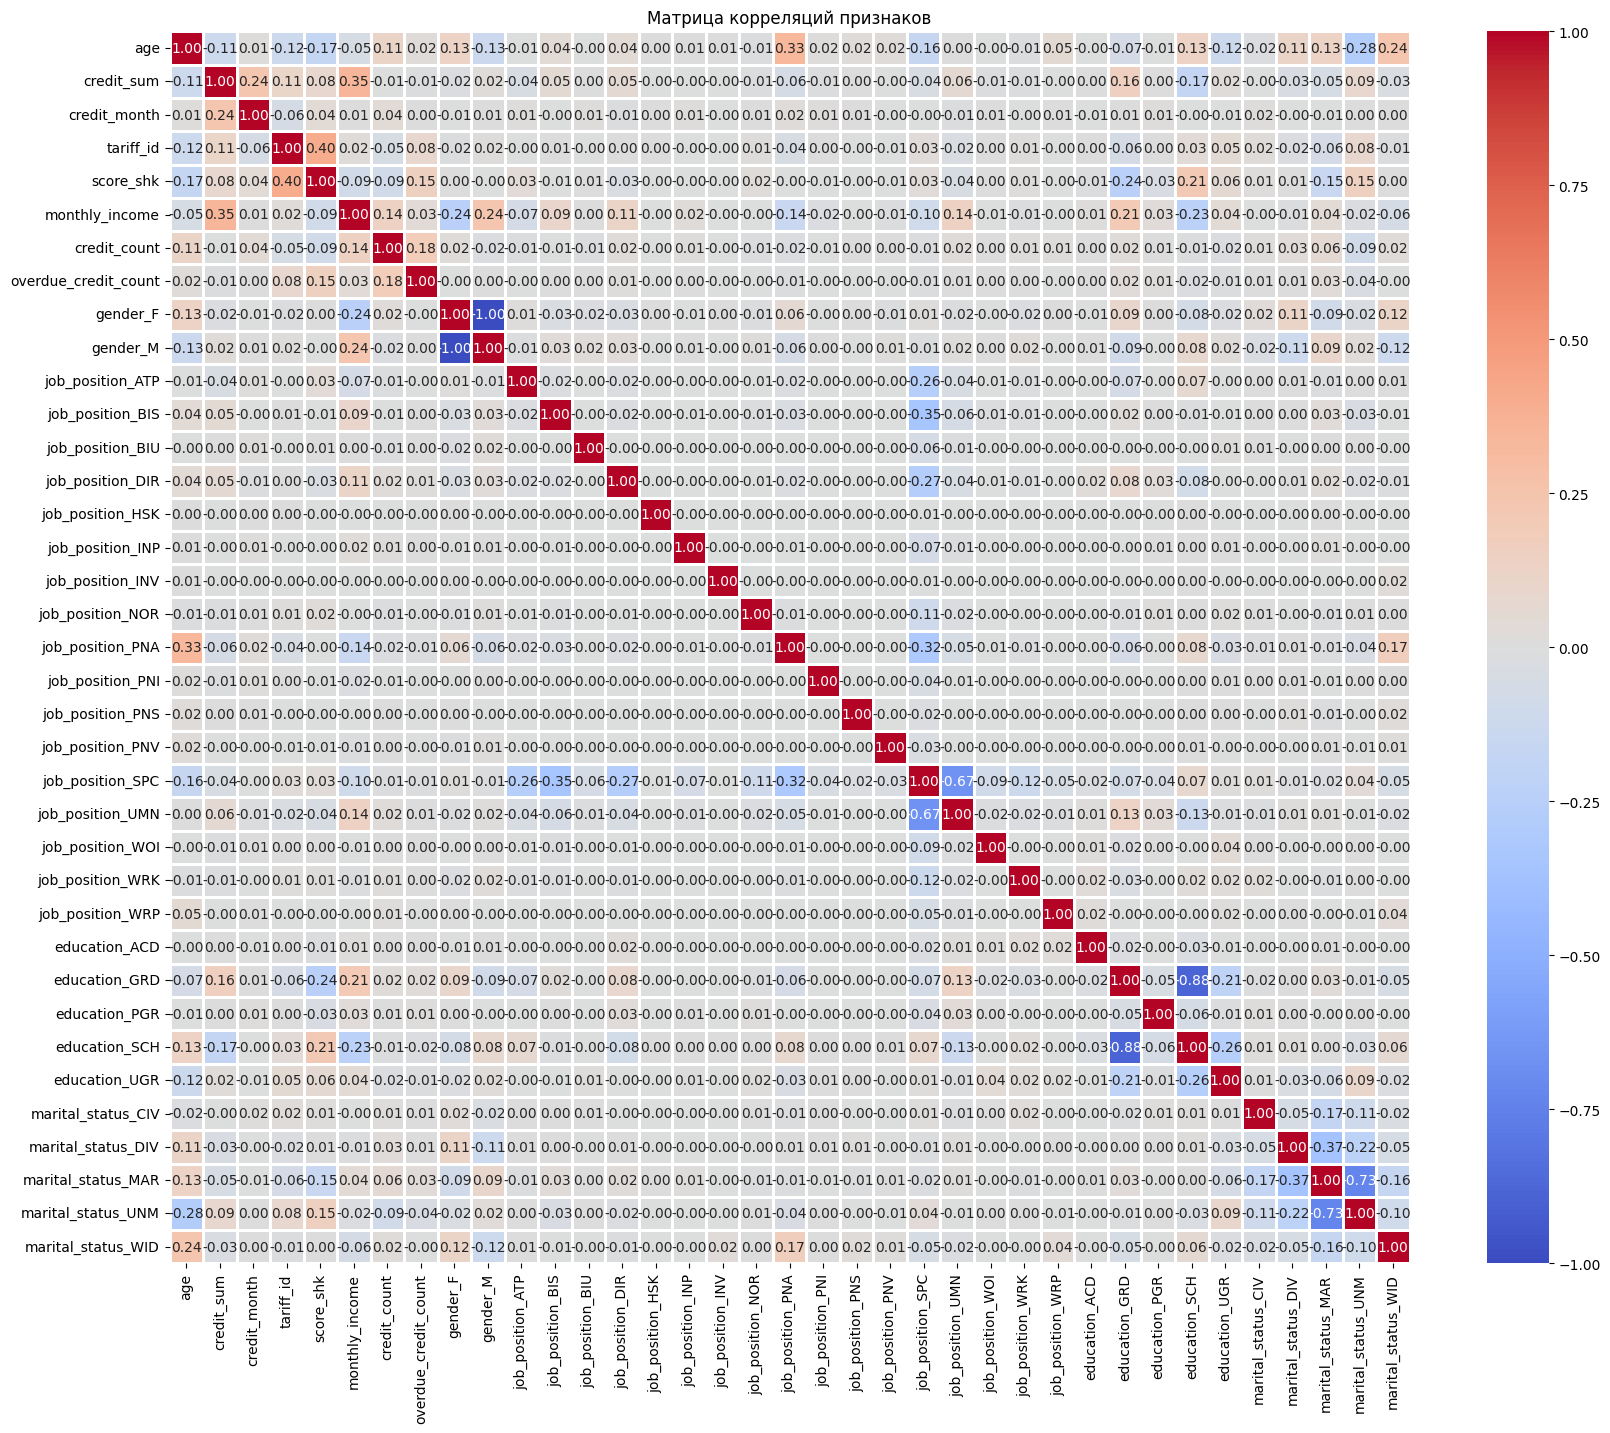

In [38]:
plt.figure(figsize=(20, 16))
sns.heatmap(data1.drop('open_account_flg', axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', linewidth=1)
plt.title('Матрица корреляций признаков');

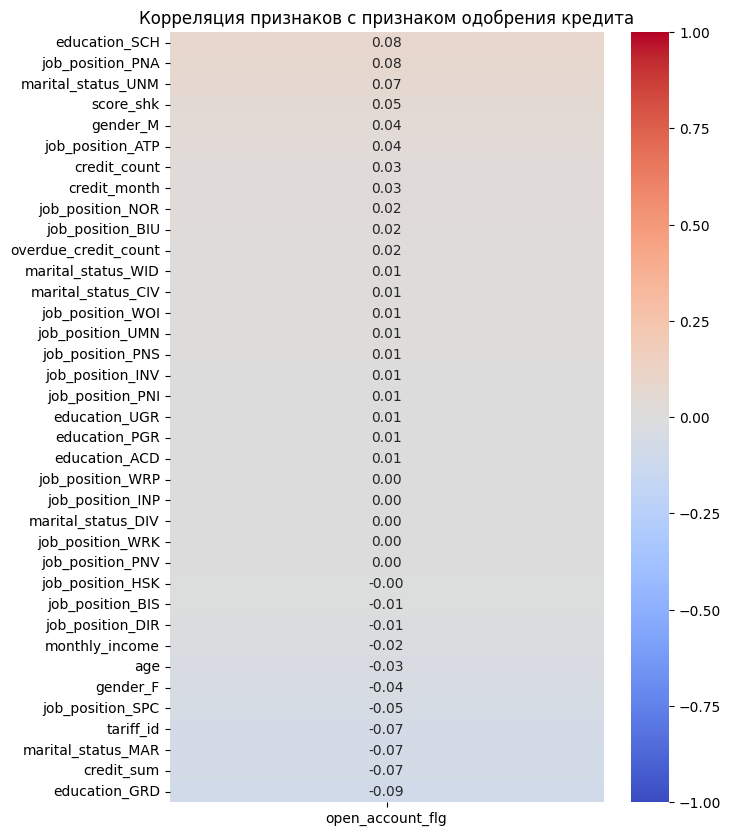

In [39]:
plt.figure(figsize=(7, 10))
sns.heatmap(pd.DataFrame(data.corr()['open_account_flg'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция признаков с признаком одобрения кредита');

Метод обертывания

In [50]:
!pip install gmdh
from gmdh import Multi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
data = data[data['open_account_flg'].notna()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
data.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


age                     0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
gender_F                0
gender_M                0
job_position_ATP        0
job_position_BIS        0
job_position_BIU        0
job_position_DIR        0
job_position_HSK        0
job_position_INP        0
job_position_INV        0
job_position_NOR        0
job_position_PNA        0
job_position_PNI        0
job_position_PNS        0
job_position_PNV        0
job_position_SPC        0
job_position_UMN        0
job_position_WOI        0
job_position_WRK        0
job_position_WRP        0
education_ACD           0
education_GRD           0
education_PGR           0
education_SCH           0
education_UGR           0
marital_status_CIV      0
marital_status_DIV      0
marital_status_MAR      0
marital_status_UNM      0
marital_status_WID      0
dtype: int64

In [55]:
Multi().fit(np.array(data[numeric_columns].drop('open_account_flg', axis=1)), data['open_account_flg'], verbose=1, limit=10).get_best_polynomial()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


LEVEL 1  [=========================] 100% :00s] (37 combinations) error=5733.556645
LEVEL 2  [=========================] 100% :00s] (36 combinations) error=5703.75954
LEVEL 3  [=========================] 100% :00s] (35 combinations) error=5673.079493
LEVEL 4  [=========================] 100% :00s] (34 combinations) error=5644.188026
LEVEL 5  [=========================] 100% :00s] (33 combinations) error=5621.783416
LEVEL 6  [=========================] 100% :00s] (32 combinations) error=5602.845014
LEVEL 7  [=========================] 100% :00s] (31 combinations) error=5585.934086
LEVEL 8  [=========================] 100% :00s] (30 combinations) error=5574.048604
LEVEL 9  [=========================] 100% :00s] (29 combinations) error=5562.467126
LEVEL 10 [=========================] 100% :00s] (28 combinations) error=5555.536065


'y = - 0.0023*x1 - 1.83876e-06*x2 - 0.1648*x4 + 0.198*x5 + 0.0092*x7 + 0.1834*x19 - 0.0395*x23 - 0.0525*x29 + 0.0477*x36 + 0.4452'

In [56]:
columns2 = [numeric_columns[i-1] for i in [1, 2, 4, 5, 7, 19, 23, 29, 36]]
columns2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['age',
 'credit_sum',
 'tariff_id',
 'score_shk',
 'credit_count',
 'job_position_NOR',
 'job_position_PNV',
 'education_ACD',
 'marital_status_MAR']

Метод вложений

In [58]:
numeric_columns.remove('open_account_flg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
e_ls1 = Lasso(random_state=1)
e_ls1.fit(data[numeric_columns], data['open_account_flg'])
list(zip(numeric_columns, e_ls1.coef_))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

[('age', -0.0),
 ('credit_sum', -2.008029186524592e-06),
 ('credit_month', 0.0),
 ('tariff_id', -0.0),
 ('score_shk', 0.0),
 ('monthly_income', 5.255957933062646e-08),
 ('credit_count', 0.0),
 ('overdue_credit_count', 0.0),
 ('gender_F', -0.0),
 ('gender_M', 0.0),
 ('job_position_ATP', 0.0),
 ('job_position_BIS', -0.0),
 ('job_position_BIU', 0.0),
 ('job_position_DIR', -0.0),
 ('job_position_HSK', -0.0),
 ('job_position_INP', 0.0),
 ('job_position_INV', 0.0),
 ('job_position_NOR', 0.0),
 ('job_position_PNA', 0.0),
 ('job_position_PNI', 0.0),
 ('job_position_PNS', 0.0),
 ('job_position_PNV', 0.0),
 ('job_position_SPC', -0.0),
 ('job_position_UMN', 0.0),
 ('job_position_WOI', 0.0),
 ('job_position_WRK', 0.0),
 ('job_position_WRP', 0.0),
 ('education_ACD', 0.0),
 ('education_GRD', -0.0),
 ('education_PGR', 0.0),
 ('education_SCH', 0.0),
 ('education_UGR', 0.0),
 ('marital_status_CIV', 0.0),
 ('marital_status_DIV', 0.0),
 ('marital_status_MAR', -0.0),
 ('marital_status_UNM', 0.0),
 ('marit

In [60]:
sel_e_ls1 = SelectFromModel(e_ls1)
sel_e_ls1.fit(data[numeric_columns], data['open_account_flg'])
list(zip(numeric_columns, sel_e_ls1.get_support()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

[('age', False),
 ('credit_sum', False),
 ('credit_month', False),
 ('tariff_id', False),
 ('score_shk', False),
 ('monthly_income', False),
 ('credit_count', False),
 ('overdue_credit_count', False),
 ('gender_F', False),
 ('gender_M', False),
 ('job_position_ATP', False),
 ('job_position_BIS', False),
 ('job_position_BIU', False),
 ('job_position_DIR', False),
 ('job_position_HSK', False),
 ('job_position_INP', False),
 ('job_position_INV', False),
 ('job_position_NOR', False),
 ('job_position_PNA', False),
 ('job_position_PNI', False),
 ('job_position_PNS', False),
 ('job_position_PNV', False),
 ('job_position_SPC', False),
 ('job_position_UMN', False),
 ('job_position_WOI', False),
 ('job_position_WRK', False),
 ('job_position_WRP', False),
 ('education_ACD', False),
 ('education_GRD', False),
 ('education_PGR', False),
 ('education_SCH', False),
 ('education_UGR', False),
 ('marital_status_CIV', False),
 ('marital_status_DIV', False),
 ('marital_status_MAR', False),
 ('marital_sta

In [61]:
columns3 = numeric_columns
columns3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['age',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'monthly_income',
 'credit_count',
 'overdue_credit_count',
 'gender_F',
 'gender_M',
 'job_position_ATP',
 'job_position_BIS',
 'job_position_BIU',
 'job_position_DIR',
 'job_position_HSK',
 'job_position_INP',
 'job_position_INV',
 'job_position_NOR',
 'job_position_PNA',
 'job_position_PNI',
 'job_position_PNS',
 'job_position_PNV',
 'job_position_SPC',
 'job_position_UMN',
 'job_position_WOI',
 'job_position_WRK',
 'job_position_WRP',
 'education_ACD',
 'education_GRD',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'marital_status_CIV',
 'marital_status_DIV',
 'marital_status_MAR',
 'marital_status_UNM',
 'marital_status_WID']